# Initial Experience of Quantum Neural Network

Translator: [unseenme](https://gitee.com/unseenme)

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/advanced/mindspore_initial_experience_of_quantum_neural_network.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/advanced/mindspore_initial_experience_of_quantum_neural_network.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/advanced/initial_experience_of_quantum_neural_network.ipynb)

## Structure of Quantum Neural Network

In MindSpore Quantum, the structure of the Quantum Neural Network (QNN) is shown in the figure below, which usually consists of three parts:

(1) One (or more) encoding circuit(s) for encoding classical data to quantum data (usually called Encoder);

(2) One (or more) training circuit(s) for training parameters in a quantum gate with parameters (usually called Ansatz);

(3) One (or more) measurement(s) for detecting whether the measurement value (for example, the measurement in the Z direction is the projection of the quantum state of a qubit on the Z axis, and the measurement obtains the expected value of the quantum state with respect to the Pauli Z operator (not limited to the Pauli Z operator, it can be replaced by other operators)) is close to the target expected value.

![mindquantum](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/mq_mix_neural_network_en.png)

Below, we use a simple example to experience how to use MindSpore Quantum.

## Simple Example

![example circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/example_circuit.png)

We build a quantum neural network as shown in the figure above, where the Encoder consists of an [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate, an [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) gate, an [RY](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RY.html) gate and an [RZ](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RZ.html) gate, Ansatz consists of an [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) gate and an [RY](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RY.html) gate, and the measurement is the Pauli `Z` operator acting on the 0th qubit.

Problem description: We regard the Encoder as the error effect of the system on the initial quantum state (the parameters $\alpha_0, \alpha_1$ and $\alpha_2$ are a fixed value obtained by preprocessing the original classical data (optional), that is, the known value, which is set to 0.2, 0.3 and 0.4 here respectively). We need to train an Ansatz to cancel out this error, so that the final quantum state is still in the $|0\rangle$ state.

Idea: Perform the Pauli `Z` operator measurement in the final state, and the measurement value at this time is the expected value of the quantum state at this time about the Pauli `Z` operator. Since $|0\rangle$ is the eigenstate of operator `Z`, and the eigenvalue is 1, it is easy to know.

$$
\langle 0|Z|0\rangle=1.
$$

That is, the target expectation is 1. Whether the state at this time is $|0\rangle$ can be verified by measuring the expected value.

Solution: By training the parameters in the Ansatz, we hope that the measurement value is close to the target expected value. In other words, we only need to make the measurement value as close as possible to the expected value corresponding to the $|0\rangle$ state with respect to the Pauli `Z` operator, then the state is $|0\rangle$, that is, the Ansatz cancels the error generated by the Encoder on the initial quantum state.

## Environment Preparation

Import the modules that this tutorial depends on.

In [1]:
import numpy as np                                          # Import the numpy library and abbreviated as np
from mindquantum.core.circuit import Circuit                # Import the Circuit module for building quantum circuits
from mindquantum.core.gates import H, RX, RY, RZ            # Import quantum gates H, RX, RY, RZ
from mindquantum.core.parameterresolver import PRGenerator  # import a parameter generator

## Building Encoder

According to the quantum circuit diagram shown, we can build the Encoder in MindSpore Quantum.

                 Circuit Summary                 
╭──────────────────────┬────────────────────────╮
│ Info                 │ value                  │
├──────────────────────┼────────────────────────┤
│ Number of qubit      │ 1                      │
├──────────────────────┼────────────────────────┤
│ Total number of gate │ 4                      │
│ Barrier              │ 0                      │
│ Noise Channel        │ 0                      │
│ Measurement          │ 0                      │
├──────────────────────┼────────────────────────┤
│ Parameter gate       │ 3                      │
│ 3 encoder parameters │ alpha0, alpha1, alpha2 │
╰──────────────────────┴────────────────────────╯

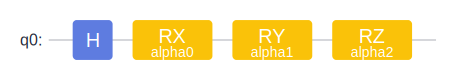

In [2]:
# pylint: disable=W0104
alpha = PRGenerator('alpha')          # Initialize a parameter generator
encoder = Circuit()                   # Initialize the quantum circuit
encoder += H.on(0)                    # The H gate acts on the 0th qubit
encoder += RX(alpha.new()).on(0)      # The RX(alpha_0) gate acts on the 0th qubit
encoder += RY(alpha.new()).on(0)      # The RY(alpha_1) gate acts on the 0th qubit
encoder += RZ(alpha.new()).on(0)      # The RZ(alpha_2) gate acts on the 0th qubit
encoder = encoder.no_grad()           # As the first layer of the entire quantum neural network, the Encoder does not need to take the derivative of the gradient in the encoding circuit, so no_grad() is added.
encoder.as_encoder()
encoder.summary()                     # Print the summary of Encoder
encoder.svg()

As can be seen from the Summary of Encoder, the quantum circuit consists of 4 quantum gates, of which there are 3 quantum gates with parameters and the parameters are $\alpha_0,\alpha_1,\alpha_2$​​​​, and the number of qubits regulated by the quantum circuit is 1.

Then, we need to assign values to the parameters in the Encoder. Since the parameters $\alpha_0, \alpha_1$ and $\alpha_2$​ in the Encoder are known values of 0.2, 0.3 and 0.4, respectively, the values are assigned direactly on the parameters and the state at this time can be printed.

In [3]:
alpha0, alpha1, alpha2 = 0.2, 0.3, 0.4              # alpha0, alpha1, alpha2 are known fixed values, assigned 0.2, 0.3 and 0.4 respectively
state = encoder.get_qs(pr={'alpha0': alpha0, 'alpha1': alpha1, 'alpha2': alpha2}, ket=True)
print(state)

(0.5669903122552596-0.1753906567580312j)¦0⟩
(0.800814626197614+0.08034947292077024j)¦1⟩


The above steps are in order to show that MindSpore Quantum can evolve the quantum circuit (if the quantum gate in the quantum circuit has parameters, you need to assign values to the parameters) and obtain the final state after evolution. It can be seen from the above printing that the final state obtained after evolution is a superposition state composed of $|0\rangle$ ​​​and $|1\rangle$, and the corresponding amplitude of each item is the value corresponding to the left side of the above-printed state.

Note:

(1) By calling the [get_qs](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs) function of the quantum circuit, we can obtain the quantum state evolved from the quantum circuit based on the all-zero state.

(2) The `pr` parameter of the [get_qs](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs) represents the parameter value in the variational quantum circuit, and the `ket` represents whether to output the quantum state as a right vector form.

## Building Ansatz

Similarly, we can also build Ansatz in MindSpore Quantum.

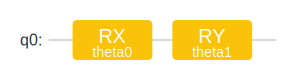

In [4]:
# pylint: disable=W0104
theta = PRGenerator('theta')                 # Initialize a parameter generator
ansatz = Circuit()                           # Initialize the quantum circuit
ansatz += RX(f'theta{0}').on(0)              # The RX(theta_0) gate acts on the 0th qubit
ansatz += RY(f'theta{1}').on(0)              # The RY(theta_1) gate acts on the 0th qubit
ansatz.as_ansatz()                           # Printing quantum circuits
ansatz.svg()

It can be seen from the summary of Ansatz that the quantum circuit consists of 2 quantum gates, of which there are 2 quantum gates with parameters and the parameters are $\theta_0,\theta_1$, and the number of qubits regulated by the quantum circuit is 1.

Then, assigning values to the parameters in Ansatz. Since Ansatz is a quantum circuit that needs to be trained, the parameters $\theta_0$​​ and $\theta_1$​​ in Ansatz can be set randomly, and are usually set to the initial value of 0 by default. We can also print the quantum state at this time, but this is not a necessary step, just to get familiar with the [get_qs](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs) function again.

In [5]:
theta0, theta1 = 0, 0                        # Assign theta0, theta1 to the initial value 0, 0
state = ansatz.get_qs(pr=dict(zip(ansatz.params_name, [theta0, theta1])), ket=True)
print(state)

1¦0⟩


As you can see from the above print, the state at this time is $|0\rangle$ ​​and the amplitude is 1. This is because for Ansatz, the default input quantum state is $|0\rangle$​​, and the parameters $\theta_0$​​ and $\theta_1$ are both 0. At this time, the [RX(0)](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) gate and the [RY(0)](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RY.html) gate are both equivalent to the [I](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.IGate.html) gate, so the entire circuit evolution process is $|0\rangle$ ​​passing after $I\cdot I$, then the final output state is of course $|0\rangle$​​​.

Then the complete quantum circuit is Encoder plus Ansatz.

                 Circuit Summary                 
╭──────────────────────┬────────────────────────╮
│ Info                 │ value                  │
├──────────────────────┼────────────────────────┤
│ Number of qubit      │ 1                      │
├──────────────────────┼────────────────────────┤
│ Total number of gate │ 6                      │
│ Barrier              │ 0                      │
│ Noise Channel        │ 0                      │
│ Measurement          │ 0                      │
├──────────────────────┼────────────────────────┤
│ Parameter gate       │ 5                      │
│ 3 encoder parameters │ alpha0, alpha1, alpha2 │
│ 2 ansatz parameters  │ theta0, theta1         │
╰──────────────────────┴────────────────────────╯

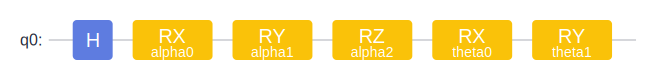

In [6]:
# pylint: disable=W0104
circuit = encoder.as_encoder() + ansatz.as_ansatz()                   # The complete quantum circuit consists of Encoder and Ansatz
circuit.summary()
circuit.svg()

From the summary of the complete quantum circuit, it can be seen that the quantum circuit consists of 6 quantum gates, of which there are 5 quantum gates with parameters and the parameters are $\alpha_0,\alpha_1,\alpha_2,\theta_0,\theta_1$, and the number of qubits regulated by the quantum circuit is 1.

## Building Hamiltonian

We perform a Pauli `Z` operator measurement on the 0th qubit to construct the corresponding Hamiltonian.

In [7]:
from mindquantum.core.operators import QubitOperator           # Import the QubitOperator module for constructing the Pauli operator
from mindquantum.core.operators import Hamiltonian             # Import the Hamiltonian module for building the Hamiltonian

ham = Hamiltonian(QubitOperator('Z0', -1))           # Perform the Pauli Z operator measurement on the 0th qubit and set the coefficient to -1 to construct the corresponding Hamiltonian
print(ham)

-1 [Z0]


As can be seen from the above printing, the Hamiltonian constructed at this time is to perform the Pauli `Z` operator measurement on the 0th qubit, and the coefficient is -1. The reason why the coefficient is set to -1 is that during the training of the quantum neural network, the gradient of the parameters in Ansatz will always decrease, and the measurement value will always decrease. If it finally converges to -1, the corresponding quantum state is $|1\rangle$ instead of $|0\rangle$​, as shown below

$$ \langle 1|Z|1\rangle=-1. $$

What we want is the $|0\rangle$ state. Therefore, set the coefficient to -1, then when the measurement value is -1, the corresponding quantum state is the $|0\rangle$ state, as shown below

$$ \langle 0|(-Z)|0\rangle=-1. $$

Note:

(1) [QubitOperator](https://www.mindspore.cn/mindquantum/docs/en/master/core/operators/mindquantum.core.operators.QubitOperator.html) is the sum of operators acting on qubits and is mainly used to construct Pauli operators; the general format is as follows: `QubitOperator(term=None, coefficient=1.0)`;

(2) [Hamiltonian](https://www.mindspore.cn/mindquantum/docs/en/master/core/operators/mindquantum.core.operators.Hamiltonian.html) is a Hamiltonian wrapper, which is mainly used to construct a Hamiltonian. The general format is as follows: `Hamiltonian(QubitOperator('X0 Y2', 0.5))`, `X0` and `Y2` indicate that the Pauli `X` operator acts on the 0th position Qubit, and the Pauli `Y` operator acts on the second qubit with a coefficient of 0.5.

## Generating Variational Quantum Circuit Simulation Operators

For the quantum circuit built above, we can generate a variational quantum circuit simulation operator in MindSpore Quantum to simulate it.

First, for convenience, we name the parameter arrays in Encoder and Ansatz as encoder_names and ansatz_names, respectively.

In [8]:
encoder_names = encoder.params_name                   # An array of all parameters in the Encoder, the system will automatically generate encoder.para_name
ansatz_names = ansatz.params_name                     # An array of all parameters in the Ansatz, the system will automatically generate ansatz.para_name

print('encoder_names = ', encoder.params_name, '\nansatz_names =', ansatz.params_name)

encoder_names =  ['alpha0', 'alpha1', 'alpha2'] 
ansatz_names = ['theta0', 'theta1']


As can be seen from the above print, encoder_names is an array composed of all parameters $\alpha_0, \alpha_1, \alpha_2$​ in Encoder, ansatz_names is an array composed of all parameters $\theta_0,\theta_1$ in Ansatz, these two arrays will be used to generate variational quantum circuit simulation operators.

Then, we obtain the operator for the evolution of the variational quantum circuit and the gradient solution by the [Simulator](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html) module.

In [9]:
# Import Simulator module
from mindquantum.simulator import Simulator

# Generate a simulator based on the mqvector backend, and set the number of bits of the simulator to the number of bits of the quantum circuit.
sim = Simulator('mqvector', circuit.n_qubits)

# Obtain the evolution of the quantum circuit based on the current quantum state of the simulator and the expectation and gradient solution operators
grad_ops = sim.get_expectation_with_grad(ham,
                                         circuit)

# An array of three parameters alpha0, alpha1, alpha2 in Encoder,
# Convert its data type to float32 and store it in encoder_data.
# MindSpore Quantum supports batch training with multiple samples. The Encoder array is two dimensions.
# The first dimension is the sample, and the second dimension is the feature (ie parameter)
encoder_data = np.array([[alpha0, alpha1, alpha2]]).astype(np.float32)

# The array composed of theta0 and theta1 parameters in Ansatz, convert its data type to float32,
# And stored in ansatzr_data, Ansatz data has only one dimension, features (ie parameters)
ansatz_data = np.array([theta0, theta1]).astype(np.float32)

# According to the data of the Encoder and Ansatz, output the measurement value of the variable sub-circuit, the derivative of the parameter in the Encoder and the derivative of the parameter in Ansatz
measure_result, encoder_grad, ansatz_grad = grad_ops(encoder_data, ansatz_data)

print('Measurement result: ', measure_result)
print('Gradient of encoder parameters: ', encoder_grad)
print('Gradient of ansatz parameters: ', ansatz_grad)

Measurement result:  [[0.29552022+0.j]]
Gradient of encoder parameters:  [[[0.+0.j 0.+0.j 0.+0.j]]]
Gradient of ansatz parameters:  [[[-0.37202556+0.j  0.87992317+0.j]]]


As can be seen from the above print, the measurement result (expected value) is 0.29552022, the derivatives of the 3 parameters in the Encoder are 0, 0, 0 (because we called no_grad() of the Encoder), and the derivatives of the 2 parameters in Ansatz are -0.37202555 and -0.87992316.

Here, what is generated by [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) is just an operator, which cannot be trained yet. It can only be trained by putting it in the quantum neural network. By training the parameters in Ansatz, the derivative of the parameters in Ansatz can be kept decreasing and close to 0, so the measurement value will be close to -1.

Note:

(1) The [get_expectation_with_grad](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html#mindquantum.simulator.Simulator.get_expectation_with_grad) of the [Simulator](https://www.mindspore.cn/mindquantum/docs/en/master/simulator/mindquantum.simulator.Simulator.html) is used to generate a variational quantum circuit to simulate the operator. The general format is as follows:

```python
Simulator.get_expectation_with_grad(ham,
                                    circ_right,
                                    circ_left,
                                    simulator_left,
                                    parallel_worker=1)
```

This function is suitable for computing the following models: $E=\left<\varphi\right|U^\dagger_l(\theta) H U_r(\theta)\left|\psi\right>$ Where `circ_right` is $U_r$, `circ_left` is $U_l$, when not provided, the default is the same circuit as `circ_right`,
`parallel_worker` specifies the number of parallels, $\left|\psi\right>$ is the quantum state of this simulator, and $\left|\varphi\right>$ is the quantum state of `simulator_left`. When the classical data to be encoded is a batch, setting this parameter reasonably can improve the calculation efficiency.

(2) MindSpore is a full-scene deep learning framework, aiming to achieve three goals of easy development, efficient execution, and unified deployment for all scenarios, provides tensor-differentiable programmability that supports heterogeneous acceleration, supports cloud, server, edge and end multiple hardware platforms.

## Building a Quantum Neural Network

In [10]:
# pylint: disable=W0104
from mindquantum.framework import MQLayer          # Import MQLayer
import mindspore as ms                             # Import mindspore

ms.set_seed(1)                                     # Set the seed for generating random numbers
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

QuantumNet = MQLayer(grad_ops)
QuantumNet

MQLayer<
  (evolution): MQOps<1 qubit mqvector VQA Operator>
  >

As can be seen from the above printing, we have successfully built a quantum machine learning layer, which can seamlessly form a larger machine learning network with other operators in MindSpore.

Note:

(1) The quantum circuit gradient calculation operators in MindSpore Quantum are all under `PYNATIVE_MODE`, so the operation mode of MindSpore needs to be set.

(2) We can also build the quantum machine learning layer by the following code, but in MindSpore Quantum, the following code has been packaged, so that we can directly use the [MQLayer](https://www.mindspore.cn/mindquantum/docs/en/master/framework/layer/mindquantum.framework.MQLayer.html) module to build the quantum machine learning layer. For more complex quantum-classical hybrid neural networks, the following construction will demonstrate its advantages.

In [11]:
from mindspore import nn

class MQLayer(nn.Cell):
    def __init__(self, expectation_with_grad, weight='normal'):
        super(MQLayer, self).__init__()
        self.evolution = MQOps(expectation_with_grad)
        weight_size = len(
            self.evolution.expectation_with_grad.ansatz_params_name)
        self.weight = Parameter(initializer(weight,
                                            weight_size,
                                            dtype=ms.float32),
                                name='ansatz_weight')

    def construct(self, x):
        return self.evolution(x, self.weight)

## Training

We use the [Adam](https://www.mindspore.cn/docs/en/master/api_python/nn/mindspore.nn.Adam.html#mindspore.nn.Adam) optimizer to optimize the parameters in Ansatz.

In [12]:
from mindspore.nn import Adam, TrainOneStepCell                   # Import Adam module and TrainOneStepCell module

opti = Adam(QuantumNet.trainable_params(), learning_rate=0.5)     # What needs to be optimized is the trainable parameters in Quantumnet, and the learning rate is set to 0.5
net = TrainOneStepCell(QuantumNet, opti)

for i in range(200):
    res = net(ms.Tensor(encoder_data))
    if i % 10 == 0:
        print(i, ': ', res)

0 :  [[0.30633032]]
10 :  [[-0.87929225]]
20 :  [[-0.9726834]]
30 :  [[-0.9935059]]
40 :  [[-0.9934296]]
50 :  [[-0.996459]]
60 :  [[-0.99859095]]
70 :  [[-0.9995031]]
80 :  [[-0.9998626]]
90 :  [[-0.9999718]]
100 :  [[-0.9999983]]
110 :  [[-0.9999993]]
120 :  [[-0.99999785]]
130 :  [[-0.9999986]]
140 :  [[-0.9999997]]
150 :  [[-1.]]
160 :  [[-0.99999994]]
170 :  [[-1.]]
180 :  [[-1.]]
190 :  [[-1.]]


As you can see from the above print, finally the measured value converges to -1.

Note:

(1) The [Adam](https://www.mindspore.cn/docs/en/master/api_python/nn/mindspore.nn.Adam.html#mindspore.nn.Adam) module updates the gradient by the adaptive moment estimation algorithm, which can optimize the parameters in Ansazt, and the input is the trainable parameters in the neural network; the general format is as follows: `nn.Adam(net.trainable_params(), learning_rate=0.5)`;

(2) The [TrainOneStepCell](https://www.mindspore.cn/docs/en/master/api_python/nn/mindspore.nn.TrainOneStepCell.html#mindspore.nn.TrainOneStepCell) module is a network training package class that wraps the network with an optimizer. The resulting cells are trained with the input "inputs", an inverse graph will be generated in the constructor to update the parameters, and there are different parallel modes available for training. The general format is as follows: `nn.TrainOneStepCell(network, optimizer, sens=1.0)`.

## Result Presentation

Since the measurements have converged to -1, we can print the parameters in Ansatz at this time.

In [13]:
theta0, theta1 = QuantumNet.weight.asnumpy()

print(QuantumNet.weight.asnumpy())

[ 2.241999  -1.0756955]


As can be seen from the above printing, the parameters $\theta_1$ and $\theta_2$ in Ansatz at this time are 2.2420275 and -1.0756909 respectively.

By [get_qs](https://www.mindspore.cn/mindquantum/docs/en/master/core/circuit/mindquantum.core.circuit.Circuit.html#mindquantum.core.circuit.Circuit.get_qs), the quantum state of the quantum circuit at the optimal parameters can be output.

In [14]:
pr = {'alpha0': alpha0, 'alpha1': alpha1, 'alpha2': alpha2, 'theta0': theta0, 'theta1': theta1}
state = circuit.get_qs(pr=pr, ket=True)

print(state)

(0.371309288022958-0.9285092418490042j)¦0⟩
(2.0012262153618066e-05+5.327365456997413e-06j)¦1⟩


As can be seen from the above printing, this is the quantum state of the quantum circuit at the optimal parameters. As can be seen from its numerical representation, this is a state close to the target state $|0\rangle$. Finally, we calculate the fidelity of this quantum state to the target state $|0\rangle$ (to verify how similar the two quantum states are), and print the fidelity.

In [15]:
state = circuit.get_qs(pr=pr)
fid = np.abs(np.vdot(state, [1, 0]))**2            # Fidelity is the modulus square of the absolute value of the vector inner product, that is, the modulus square of the inner product of the vector corresponding to the quantum state and the vector [1,0] corresponding to the |0> state at this time is calculated.

print(fid)

0.9999999995711284


It can be seen that the fidelity at this time is 100.00%, that is to say, the similarity between this state and the target state $|0\rangle$ is 100.00%.

To sum up, we built a simple quantum neural network. By training the parameters in Ansatz, the error generated by the Encoder on the initial quantum state was offset, so that the final quantum state was still $|0\rangle$, and the fidelity reached 100.00%.

So far, we have completed the first experience of quantum neural network by MindSpore Quantum! Hurry up and experience the fun of quantum programming!

In [16]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Sun Dec 31 21:30:32 2023
